<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-и-подготовка-к-работе" data-toc-modified-id="Изучение-данных-и-подготовка-к-работе-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных и подготовка к работе</a></span><ul class="toc-item"><li><span><a href="#Методы-и-формулы-для-расчетов" data-toc-modified-id="Методы-и-формулы-для-расчетов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Методы и формулы для расчетов</a></span><ul class="toc-item"><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Умножение матриц</a></span></li></ul></li><li><span><a href="#Общая-информация-о-датасете-и-данных.-Предобработка-данных." data-toc-modified-id="Общая-информация-о-датасете-и-данных.-Предобработка-данных.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Общая информация о датасете и данных. Предобработка данных.</a></span></li></ul></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Итоги-и-выводы-по-проекту" data-toc-modified-id="Итоги-и-выводы-по-проекту-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоги и выводы по проекту</a></span></li></ul></div>

# Описание проекта

Страховая компания «Хоть потоп» предоставила данные о клиентах.

Нужно разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

# Цель:

Нужно защитить данные о клиентах компании «Хоть потоп», чтобы при преобразовании данных качество моделей машинного обучения не ухудшилось.

# Описание данных:

Набор данных находится в файле `/datasets/insurance.csv`. 

Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.

Целевой признак: количество страховых выплат клиенту за последние 5 лет.

# Краткий план работы:

- Загрузить и изучить данные.

- Ответить на вопрос и обосновать решение: Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

 - Изменится. Привести примеры матриц.

 - Не изменится. Указать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.
 
- Предложить алгоритм преобразования данных для решения задачи. Обосновать, почему качество линейной регрессии не поменяется.

- Запрограммировать этот алгоритм, применив матричные операции. 

- Проверить, что качество линейной регрессии из sklearn не отличается до и после преобразования. Применить метрику R2 для оценки качества модели.

## Изучение данных и подготовка к работе

Настроим окружение: импортируем все необходимые библиотеки.

In [1]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

### Методы и формулы для расчетов

In [2]:
# метод покажет количество и выведет уникальные значения столбцов датасета
def check_columns(df):
    
    for column in df.columns:        
        print('Количество уникальных значений столбца', column, '-', df[column].nunique())        
        print(df[column].sort_values().unique())         
        print('____________________________________')

In [3]:
#боксплот для признаков датасета
def boxplot_df(df, title):    
    names = df.columns    
    ncols = len(names)    
    
    fig, axes = plt.subplots(1,ncols, figsize=(20, 5))    
    for name, ax in zip( names, axes.flatten()):        
        sns.boxplot(y=name, data=df, orient='v', ax=ax)        
        plt.suptitle(title)   

In [4]:
# метод найдет и посчитает выбросы
def find_outliers(df,column):
    
    # определим 25 и 75% квантили
    q25=np.array(df[column].quantile(0.25))    
    q75=np.array(df[column].quantile(0.75))
    
    # границы нормального размаха
    limit_of_normal_range_left=q25-1.5*(q75-q25)    
    limit_of_normal_range_right=q75+1.5*(q75-q25)
    
    # определим индексы объектов - выбросов
    del_index = []    
    for index_value, value in zip(df[column].index,df[column]):        
        if limit_of_normal_range_right <= value or value <= limit_of_normal_range_left:            
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления в столбце', column, ': ', len(del_index))    
    print('Процент удаленных данных {:.2f}'.format(len(del_index)*100/df.shape[0]))    
    print('___________________________________________________________')
    
    return del_index

In [5]:
#выделение независимых признаков и целевой переменой, масштабирование данных
def  split_scaled_df(df):    
    #выделение независимых признаков и целевой переменой
    X = df.drop('страховые_выплаты', axis = 1)
    y = df['страховые_выплаты']  
    
    print('Размер выборки с независимыми признаками', X.shape)    
    print('Размер выборки с целевым признаком', y.shape)
    
    scaler = StandardScaler()    
    scaler.fit(X)
    X_scaled = scaler.transform(X)    
    print('Размер выборки с масштабированными независимыми признаками', X_scaled.shape)    
    return X, y, X_scaled

In [6]:
#метод проверит изменилось или качество предсказания после преобразования признаков
def transform_matrix(features, target, p_matrix):     
    # Создадим столбец с единицами
    bias_column = np.ones((features.shape[0], 1))     
    # Объединим его с матрицей признаков
    features_bias_column = np.concatenate((bias_column, features), axis = 1)     
    #Расчитаем веса w для исходных признаков (масштабированных и не масштабированных)
    w = np.linalg.inv(features_bias_column.T.dot(features_bias_column)).dot(features_bias_column.T).dot(target)    
    #Расчитаем вектор предсказаний по исходным признакам по формуле 𝑎=𝑋𝑤
    a = features_bias_column.dot(w)    
    #Проведем преобразование признаков
    X_p = features.dot(p_matrix)      
    # Создадим столбец с единицами
    bias_column_p = np.ones((features.shape[0], 1))    
    # Объединим его с преобразованной матрицей признаков
    X_p_bias_column = np.concatenate((bias_column_p, X_p), axis = 1)
    
    print('Преобразованная матрица с искусственным столбцом с единицами')
    
    #Выведем данные после преобразования
    display(pd.DataFrame(X_p_bias_column))    
    #Расчитаем веса  𝑤1  для преобразованных признаков 
    w1 = np.linalg.inv(X_p_bias_column.T.dot(X_p_bias_column)).dot(X_p_bias_column.T).dot(target)    
    #Расчитаем вектор предсказаний по преобразованным признакам по формуле  𝑎=𝑋𝑤
    a1 = X_p_bias_column.dot(w1)    
    #Получим вектор разниц между предсказаниями по исходным признакам  𝑎  и преобразованным  𝑎1 
    diff_1 = a - a1    
    #Просуммируем все элементы вектора diff, чтобы убедиться, что расхождения минимальны.
    diff_1.sum()
    
    print('Результат проверки качества модели: разниц между предсказаниями по исходным признакам  𝑎 и преобразованным 𝑎1',\
          diff_1.sum())     
    return X_p

In [7]:
#  метод для передачи выборок в обучающую модель линейной регрессии 
def train_model(features,target, p_matrix, emissions, data_scaling):
    
    #  обучим модель линейная регрессия 
    model = LinearRegression()    
    model.fit(features, target)    
    predictions = model.predict(features)        
    # расчитаем метрику R2
    r2 = r2_score(target, predictions)    
    
    #Проведем преобразование признаков
    X_p = features.dot(p_matrix)    
    model_p = LinearRegression()    
    model_p.fit(X_p, target)    
    predictions_p = model_p.predict(X_p)       
    # расчитаем метрику R2
    r2_p = r2_score(target, predictions_p)
    
    # строка для накопительной таблицы по моделям и параметрам
    row_tab_metrics = [emissions, data_scaling, r2, r2_p]    
    return row_tab_metrics

# создаем накопительную таблицу для сбора данных по всем лучшим моделям алгоритма Деревр Решений для сравнения
tab_metrics = pd.DataFrame(columns = ['Выбросы в данных', 'Данные масштабированы', 
                                         'R2 на исходных данных', 'R2 на преобразованных данных'])

<a id = 'matrix'></a>

#### Умножение матриц

Необходимо ответить на вопрос и обосновать решение: Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

- Изменится. Привести примеры матриц.

- Не изменится. Указать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Обозначения:

- `X` — матрица признаков (нулевой столбец состоит из единиц)

- `y` — вектор целевого признака

- `P` — матрица, на которую умножаются признаки

- `w` — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Выпишем формулы, которые будем использовать в  доказательстве того, что при умножении признаков на обратимую матрицу качество линейной регрессии не меняется.

- $(A B)^{-1} = B^{-1} A^{-1}$

- $(A B)^T = B^T A^T$

- $A A^{-1} = E$

Заменим `w`  в формуле предсказания (`a = Xw`) формулой обучения ($w = (X^T X)^{-1} X^T y$):

$$
a = X(X^T X)^{-1} X^T y
$$


Представим новую матрицу признаков `Z` как произведение матрицы `X`  на матрицу `P` - обратимая матрица с некими значениями, на которую может быть умножена матрица `X`:

$$
Z = XP
$$

Заменим `X`  на `Z`  в формуле предсказания (a = Xw) .

$$
a1 = Z(Z^T Z)^{-1} Z^T y
$$

Докажем, что `a1 = a`.

Заменим все `Z` на `XP`:

$$
a1 = XP((XP)^TXP)^{-1}(XP)^Ty
$$ 

Воспользуемся свойством транспорнированной матрицы $(AB)^T = B^T A^T$, преобразуем выражение:

$$
a1 = XP(P^TX^TXP)^{-1}P^TX^Ty
$$

Сгруппируем некоторые элементы выражения и продолжим преобразования (воспользуемся формулой для преобразования $(AB)^{-1} = B^{-1} A^{-1}$):

$$
a1 = XP(P^T(X^TX)P)^{-1}P^TX^Ty
$$
    
$$
a1 = XPP^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$

Выражения $ P P ^{-1}$  и $(P^T)^{-1}P^T$заменим на единичную матрицу (по правилу $A A^{-1} = E$)

$$
a1 = XE(X^TX)^{-1}EX^Ty
$$

$$
a1 = X(X^TX)^{-1}X^Ty
$$

Выражение $(X^TX)^{-1}X^Ty$ можно заменить на `w`:

$$
a1 = Xw
$$

А значит `a1 = a`.

В данном случае, параметры линейной регрессии в исходной задаче  и в преобразованной  связаны следующим образом:

$$
a1 = a 
$$

Можем записать следующим образом:

$$
Zw1 = Xw
$$

Проведем замену `Z` на `XP` и получим :

$$
XPw1 = Xw
$$

Матрица `𝑋` является прямоугольной (не квадратной), а мы хотим выразить взаимосвязь между векторами `𝑤` и `𝑤1`, то можем сделать это с использованием псевдообратной матрицы.

Если `Х` - прямоугольная матрица, тогда $Х^⁺$ - это матрица, которая "приближает" обратную матрицу $Х^{-1}$, чтобы решить систему уравнений в случае, когда матрица `Х` не является квадратной.

Мы можете использовать псевдообратную матрицу $X^+$ (псевдообратная матрица матрицы `X`) следующим образом:

Умножим обе стороны на псевдообратную матрицу $X^+$:

$$
X^+ XPw1 = X^+ Xw
$$
Поскольку умножение на псевдообратную матрицу даёт единичную матрицу (подобно умножению на обратную матрицу для квадратной матрицы), остаётся:

$$
Pw1 = w
$$

**Вывод**

Значение предсказания  `a` не меняется, если умножить матрицу признаков `X` на обратимую матрицу `P`.

Отвечая на вопрос: изменится ли качество линейной регрессии при умножении признаков на обратимую матрицу, можно утверждать, что  качество линейной регрессии при умножении признаков на обратимую матрицу не изменится. 

Параметры линейной регрессии `w` в исходной задаче  `w1` и в преобразованной  связаны следующим образом: `Pw1 = w`.

<a id = 'data'></a>

### Общая информация о датасете и данных. Предобработка данных.

Ознакомимся с данными таблицы и их структурой.

Загрузим в датафрейм данные, с которыми будем работать.

Посмотрим на несколько первых записей в датафрейме c помощью метода head().

Выведем общую информацию по таблице c помощью метода info().

In [8]:
pth1 = '/datasets/insurance.csv'
pth2 = 'insurance.csv'
if os.path.exists(pth1):    
    data = pd.read_csv(pth1)    
elif os.path.exists(pth2):    
    data = pd.read_csv(pth2)    
else:    
    print('Something is wrong') 

In [9]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Типы данных в датафрейме:

Категориальные: `Пол`.

Количественные: `Возраст`, `Зарплата`, `Члены семьи`, `Страховые выплаты`, тип float и int.

Логические: логических нет.

В датафрейме 5000 объектов и 5 признаков (характеристик) для них, пропусков нет.

Из признаков модем выделить 4 независимых признака и один целевой признак `Страховые выплаты`.



Вызывем метод `columns` для изучения корректности названий заголовков датафреймов.

In [11]:
data.columns.tolist()

['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']

В наборе данных есть общие элементы беспорядочных имен столбцов: разделители слов ввиде пробела, разные регистры.

Переведем все в один регистр, удалим пробелы между словами.

In [12]:
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.lower()
data.columns.tolist()

['пол', 'возраст', 'зарплата', 'члены_семьи', 'страховые_выплаты']

Рассмотрим уникальные значения по столбцам, воспользуемся методом `check_columns()`.

In [13]:
check_columns(data)

Количество уникальных значений столбца пол - 2
[0 1]
____________________________________
Количество уникальных значений столбца возраст - 46
[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 65.]
____________________________________
Количество уникальных значений столбца зарплата - 524
[ 5300.  6000.  7400.  8900.  9800. 10000. 10600. 10800. 11000. 11200.
 11300. 12200. 12900. 13000. 13200. 13300. 13400. 13500. 13800. 13900.
 14100. 14300. 14400. 14500. 14600. 14700. 15000. 15100. 15200. 15600.
 15700. 15900. 16000. 16200. 16300. 16400. 16500. 16600. 16700. 17000.
 17100. 17300. 17400. 17500. 17600. 17700. 17800. 17900. 18100. 18200.
 18300. 18400. 18600. 18700. 18800. 18900. 19000. 19100. 19200. 19300.
 19400. 19600. 19700. 19900. 20000. 20100. 20200. 20300. 20400. 20500.
 20600. 20700. 20800. 20900. 21000. 21100. 21200. 21300. 21400. 21500.
 21600. 217

На первый взгляд данные нормальные, каких-либо аномальных значений не наблюдается.

Переведем значения в столбцах `возраст` и `зарплата` из `float` в `int`.

In [14]:
data['возраст'] = data['возраст'].astype(int)
data['зарплата'] = data['зарплата'].astype(int)

Посмотрим на количество дубликатов в таблице

In [15]:
data.duplicated().sum()

153

Так как основная задача проекта заключается в шифровании данных клиентов и мы не знаем что явилось причиной возникновения дубликатов - возможно это разные клиенты с одинаковыми данными, а возможно задваивание произошло по техническим причинам или по ошибке оператора. Удалять дубликаты на начальной выборке не будем. Создадим копии датасета и на копии удалим дубликаты.

Дубликаты составляют всего 3% от всех данных, их можно оставить без серьезных последствий для результата регрессии.

Но есть и негативные факторы влияния дубликатов на качество модели:

- В случае, если дубликаты представляют собой дополнительные наблюдения с одинаковыми значениями признаков и целевой переменной, модель может подстроиться под эти дубликаты и переобучиться на них.

- Дубликаты могут оказать влияние на способность модели обобщать на новые данные. В результате, модель может показывать недостаточно хорошие результаты на реальных тестовых данных.

- В некоторых случаях, дубликаты могут исказить статистику и влиять на важность признаков. Например, если дубликаты сосредоточены в определенном диапазоне значений, это может повлиять на восприятие моделью важности других признаков.

Если дубликаты составляют не большой процент данных и нет особых причин полагать, что они искажают структуру данных или вводят сильное смещение, то вероятность серьезного влияния на результат регрессии довольно низкая. 

В дальнейшем посмотрим оказывают ли дубликаты влияние на качество модели.

Удалим дубликаты на копии датасета.

In [16]:
# копия датасета, на которай проведем удаление дубликатов
data_cut = data.copy()
data_cut = data_cut.drop_duplicates().reset_index(drop = True)

In [17]:
print("Число дубликатов в датасете:", data_cut.duplicated().sum())
print("_______________________",)
data_cut.info()

Число дубликатов в датасете: 0
_______________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   пол                4847 non-null   int64
 1   возраст            4847 non-null   int64
 2   зарплата           4847 non-null   int64
 3   члены_семьи        4847 non-null   int64
 4   страховые_выплаты  4847 non-null   int64
dtypes: int64(5)
memory usage: 189.5 KB


Удалили 153 объекта, датасет созданный на копии уменьшился до 4847 строк.

Посмотрим на распеределение признаков на полном датасета

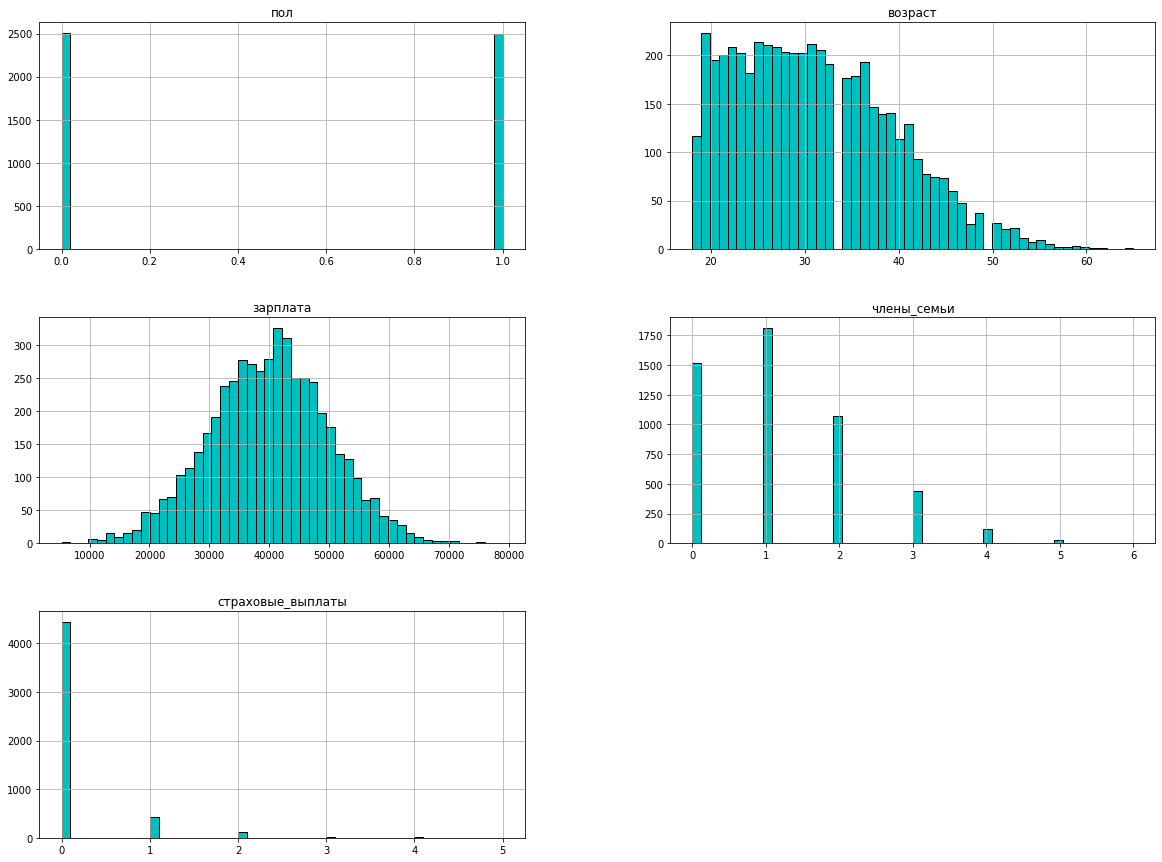

In [18]:
data.hist(bins=50, figsize=(20,15), color='c', edgecolor='black', linewidth=1)
plt.show()

Наблюдаем одинаковое количество клиентов разного пола. 

Гистограмма возраста показывает большую часть равномерное распределение, а потом перекос в право - это обусловленно возрастом вхождения в договорные отношения, с 35 летнего возраста наблюдается снижение количества пользователей страхового сервиса.

Распределение зарплаты нормальное.

Чаще всего клиенты одинокие люди ли имеют одного члена в семье.

Страховые выплаты - редкое явление.

Посмотрим имеются ли выбросы в данных по столбцам `возраст`, `зарплата`, `члены_семьи`.

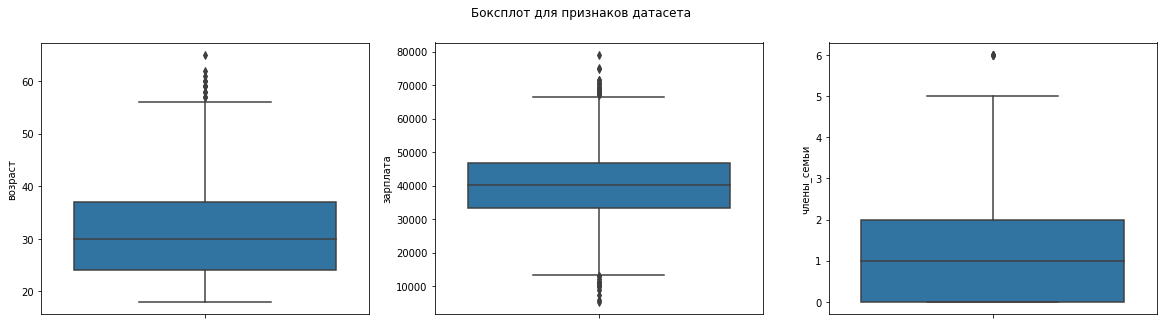

In [19]:
boxplot_df(data_cut[['возраст', 'зарплата', 'члены_семьи']], 'Боксплот для признаков датасета')

Боксплот показывает, что в столбцах есть данные, выходящие за границы нормальных значений:

- `возраст` клиенты после 55 лет редко встречаются в выборке,

- `зарплата` - медианное значение 40000, выбросы есть как в минимуме и так и максимальный значениях,

- `члены_семьи` - более 5 человек редко встречается.

Эти данные будут мешать модели обучаться, отвлекая её. Поэтому их необходимо удалить.

Удалим выбросы, для этого создадим копию датасета и в дальнейшем будем рассматривать данных с выбросами и без.

Вызовем метод `find_outliers()` для удаления выбросов по рассмотреным столбцам.

In [20]:
# столбцы с выбросами
outlier_columns = [(data_cut,"возраст"), (data_cut,"зарплата"), (data_cut,"члены_семьи")]

# удалим выбросы, возовем метод find_outliers()
for df_cut,column in outlier_columns:    
    indexes = find_outliers(df_cut,column)    
    df_cut = df_cut.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления в столбце возраст :  12
Процент удаленных данных 0.25
___________________________________________________________
Количество строк, выбранных для удаления в столбце зарплата :  34
Процент удаленных данных 0.70
___________________________________________________________
Количество строк, выбранных для удаления в столбце члены_семьи :  39
Процент удаленных данных 0.81
___________________________________________________________


Данные датасет уменьшились не значительно. Удалили 1.8% данных.

**Вывод**

В процессе ознакомления с данными и предобработки выявленно следующее:

- пропуски в данных - отсутствуют,

- типы данных в столбцах - корректны,

- названия столбцов корректны (преобразовали),

- дубликаты - удалили,

- выбросы - удалены, для этого создана копия основного датасета,

- за целевой признак примем столбец страховые_выплаты, остальные столбцы - признаки, по которым будем проводить предсказывание целевого признака,

- для предсказания целевого признака будем использовать линейную регрессию.

<a id = 'algorithm'></a>

## Алгоритм преобразования

Предложим алгоритм преобразования данных для решения задачи проекта. 

Обоснуем, почему качество линейной регрессии не поменяется.

Для защиты информации на этапе поиска коэффициентов регрессии и предсказаний регрессии будем умножать матрицу признаков на обратимую матрицу `P` , которая будет генерироваться случайным образом.

Этапы алгоритма:

- Генерация случайной обратимой матрицы: Сгенерируем случайную матрицу `P` такого же размера, что и матрица `X`, и удостоверимся, что она обратима.

- Построение зашифрованных данных: Для шифрования умножим матрицу `X` на сгенерированную обратимую матрицу `P`. Получим зашифрованные данные `Z`:

$$
Z = XP
$$

- Построение регрессионной модели: Постройм линейную регрессионную модель, используя зашифрованные данные `Z` в качестве входных данных и соответствующие выходные данные `a1`. Найдем коэффициенты регрессии (веса) с помощью обучения модели на зашифрованных данных.


- Восстановление исходных данных:  для восстановления исходных данных `X` из преобразованных данных `Z` можно использовать обратную матрицу $P^{-1}$ умножив матрицу зашифрованных признаков `Z` на обратную матрицу  $P^{-1}$:

$$
X = ZP^{-1}
$$

Так как по условию задачи случайно сгенерированная матрица `P` при умножении на матрицу признаков `Х` должна давать матрицу такого же размера как исходная, а матрица `P` должна быть квадратной, то размер матрицы `P` устрановим равным количеству признаков матрицы `Х`. 
Имем 4 признака в оcновной матрице, значит сгенерируем матрицу `P`размером 4х4.

In [21]:
p_matrix = np.random.randint(100,size = (4, 4))
p_matrix

array([[28, 81, 78, 63],
       [80, 95, 63, 49],
       [23, 14, 10, 77],
       [41,  4, 69, 17]])

Теперь проверим сгенерированную матрицу на обратимость, если матрица не обратима получим ошибку.

In [22]:
p_matrix_inverted = np.linalg.inv(p_matrix)
p_matrix_inverted

array([[-0.0177213 ,  0.01424748,  0.00401018,  0.00644302],
       [ 0.0072496 ,  0.00589208, -0.00690487, -0.01257422],
       [ 0.00943217, -0.00774275, -0.00536823,  0.01167778],
       [ 0.00275031, -0.00432148,  0.01374177, -0.00115491]])

Ранее мы доказали, что предсказания модели алгоритма машинного обучения при преобразовании матрицы признаков не поменяются. 

Качество модели при преобразовании матрицы признаков на случайную обратимую матрицу может остаться практически неизменным по следующим причинам:

- линейная регрессия, если мы преобразуем входные данные-признаки линейно (умножением на обратимую матрицу), найдет для новых приобразованных признаков решение такое же, как и для исходных признаков,

- обратимая матрица сохраняет линейные зависимости между признаками, обратимая матрица является невырожденной и не уничтожает информацию о линейных взаимосвязях между признаками,

- мы используем случайную обратимую матрицу, изменения, которые она внесет в данные, могут быть разнообразными и случайными. При этом сохраняется общий характер данных и их линейные зависимости, что позволяет модели оставаться пригодной для предсказаний,

- умножение матрицы признаков на обратимую матрицу может изменить значения коэффициентов линейной регрессии, но они останутся пропорциональными исходным, то есть общая форма зависимостей в данных сохранится. 

Тестирование и анализ результатов после преобразования данных подтвердит или опровергнет изложенное.

Подкрепим теоритические выводы примером на данных из датасета. 

Для этого расчитаем вектора предсказаний  `a` и  `a1` по формулам и сравним их между собой.

Выделим независимые признаки и целевой признак в исходном датасете и датасете на очищенных от выбросов данных, вопользуемся методом `split_scaled_df()`.

In [23]:
#выделение признаков в исходном датасете и масштабирование данных
X, y, X_scaled = split_scaled_df(data)

Размер выборки с независимыми признаками (5000, 4)
Размер выборки с целевым признаком (5000,)
Размер выборки с масштабированными независимыми признаками (5000, 4)


In [24]:
#выделение признаков в очищенном от выбросов датасете  и масштабирование данных
X_cut, y_cut, X_cut_scaled = split_scaled_df(data_cut)

Размер выборки с независимыми признаками (4762, 4)
Размер выборки с целевым признаком (4762,)
Размер выборки с масштабированными независимыми признаками (4762, 4)


Проверим измениться или качество предсказания после преобразования признаков, воспользуемся методом `transform_matrix()`. Данный метод пройдется по алгоритму преобразования, подсчитает предсказания по исходных данных и перобразованных, проверит , что расхождения в предсказаниях незначительные. 

In [25]:
#для исходных признаков (на не масштабированных данных) 
X_p = transform_matrix(X, y, p_matrix)

Преобразованная матрица с искусственным столбцом с единицами


,0,1,2,3,4
0,1.0,1144149.0,698380.0,498730.0,3821289.0
1,1.0,877721.0,536374.0,382967.0,2928271.0
2,1.0,485320.0,296755.0,211827.0,1618421.0
3,1.0,960862.0,585803.0,418461.0,3211963.0
4,1.0,602568.0,368141.0,262842.0,2011135.0
...,...,...,...,...,...
4995,1.0,823422.0,502468.0,358902.0,2750306.0
4996,1.0,1207961.0,736834.0,526211.0,4036483.0
4997,1.0,781382.0,476508.0,340398.0,2611314.0
4998,1.0,754011.0,459983.0,328671.0,2519092.0


Результат проверки качества модели: разниц между предсказаниями по исходным признакам  𝑎 и преобразованным 𝑎1 -2.9156863372360384e-05


In [26]:
#Дешифруем матрицу
X_returned = X_p.dot(np.linalg.inv(p_matrix)) 
    
#Выведем данные после дешифровки
pd.DataFrame(X_returned.round().astype (int))

,0,1,2,3
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


Данные не изменились при дешифровки.

In [27]:
#для исходных признаков (на масштабированных данных) 
X_p_scaled = transform_matrix(X_scaled, y, p_matrix)

Преобразованная матрица с искусственным столбцом с единицами


,0,1,2,3,4
0,1.0,138.493789,207.236649,150.656707,193.756135
1,1.0,102.935284,85.110649,20.260588,6.553949
2,1.0,-135.272088,-133.948944,-187.037651,-239.955593
3,1.0,-87.865188,-187.390463,-99.385240,-94.230379
4,1.0,-76.901119,24.008189,-33.349840,-80.090748
...,...,...,...,...,...
4995,1.0,-35.454857,-117.084274,-53.194986,-100.261337
4996,1.0,22.648321,-29.595532,-54.766478,48.895669
4997,1.0,-115.466777,-209.677752,-114.729238,-160.708323
4998,1.0,-5.726721,-23.197176,118.216470,-16.852761


Результат проверки качества модели: разниц между предсказаниями по исходным признакам  𝑎 и преобразованным 𝑎1 1.1846467275027084e-13


In [28]:
#для исходных признаков (на очищенной выборке с немасштабированными данными) 
X_p_cut = transform_matrix(X_cut, y_cut, p_matrix)

Преобразованная матрица с искусственным столбцом с единицами


,0,1,2,3,4
0,1.0,1144149.0,698380.0,498730.0,3821289.0
1,1.0,877721.0,536374.0,382967.0,2928271.0
2,1.0,485320.0,296755.0,211827.0,1618421.0
3,1.0,960862.0,585803.0,418461.0,3211963.0
4,1.0,602568.0,368141.0,262842.0,2011135.0
...,...,...,...,...,...
4757,1.0,823422.0,502468.0,358902.0,2750306.0
4758,1.0,1207961.0,736834.0,526211.0,4036483.0
4759,1.0,781382.0,476508.0,340398.0,2611314.0
4760,1.0,754011.0,459983.0,328671.0,2519092.0


Результат проверки качества модели: разниц между предсказаниями по исходным признакам  𝑎 и преобразованным 𝑎1 -1.5629795256440638e-05


In [29]:
#для исходных признаков (на очищенной выборке с масштабированными данными) 
X_p_cut_scaled = transform_matrix(X_cut_scaled, y_cut, p_matrix)

Преобразованная матрица с искусственным столбцом с единицами


,0,1,2,3,4
0,1.0,140.387073,208.726441,152.595058,196.336507
1,1.0,104.545073,86.632677,22.200017,7.212674
2,1.0,-137.580610,-134.605996,-189.440993,-243.906652
3,1.0,-86.057742,-187.683730,-95.774734,-93.244037
4,1.0,-78.999472,23.438993,-35.685758,-83.144114
...,...,...,...,...,...
4757,1.0,-33.479755,-116.987217,-49.335917,-100.076035
4758,1.0,24.197255,-28.604726,-53.154656,51.686072
4759,1.0,-114.159990,-210.316949,-111.361506,-161.203483
4760,1.0,-2.570571,-23.533268,124.652137,-16.745886


Результат проверки качества модели: разниц между предсказаниями по исходным признакам  𝑎 и преобразованным 𝑎1 1.5397199574357368e-13


Видим, что данные потеряли свои оригинальные значения, отражаются различные числа, по которым определить информацию не возможно. 

Многократно проверили на разных данных.

Полученные результаты подтверждают, что сумма расхождений незначительная, значит `𝑎` равен `𝑎1`.

На масштабированных данных результат получаем лучше.

**Вывод**

Предложили алгоритм преобразования данных для решения задачи проекта, обосновали, почему качество линейной регрессии не поменяется.

На реальном примере показали, что преобразование не приводит к различиям в предсказаниях модели и не ухудшает качество модели.

Подтвердили вывод - суммы расхождений незначительные.

<a id = 'R2'></a>

## Проверка алгоритма

Создадим модель Линейной Регрессии для исходных данных и преобразованных, сравним метрики качества на разных данных.

Сравним показатели качества моделей. Вызовем метод `train_model()`, выведем накопительную таблицу, где будут указаны особенности входных данных и приведены показатели метрики R2 на исходных данных и преобразованных данных.

In [30]:
#исходный датасет на немасштабированых данных
tab_metrics.loc[len(tab_metrics.index)] = train_model(X, y, p_matrix, 'есть', 'нет')
tab_metrics

,Выбросы в данных,Данные масштабированы,R2 на исходных данных,R2 на преобразованных данных
0,есть,нет,0.424946,0.424946


In [31]:
#исходный датасет на масштабированых данных
tab_metrics.loc[len(tab_metrics.index)] = train_model(X_scaled, y, p_matrix, 'есть', 'да')
tab_metrics

,Выбросы в данных,Данные масштабированы,R2 на исходных данных,R2 на преобразованных данных
0,есть,нет,0.424946,0.424946
1,есть,да,0.424946,0.424946


In [32]:
#исходный датасет на очищенной выборке с немасштабированными данными
tab_metrics.loc[len(tab_metrics.index)] = train_model(X_cut, y_cut, p_matrix, 'нет', 'нет')
tab_metrics

,Выбросы в данных,Данные масштабированы,R2 на исходных данных,R2 на преобразованных данных
0,есть,нет,0.424946,0.424946
1,есть,да,0.424946,0.424946
2,нет,нет,0.423253,0.423253


In [33]:
#исходный датасет на очищенной выборке с масштабированными данными
tab_metrics.loc[len(tab_metrics.index)] = train_model(X_cut_scaled, y_cut, p_matrix, 'нет', 'да')
tab_metrics

,Выбросы в данных,Данные масштабированы,R2 на исходных данных,R2 на преобразованных данных
0,есть,нет,0.424946,0.424946
1,есть,да,0.424946,0.424946
2,нет,нет,0.423253,0.423253
3,нет,да,0.423253,0.423253


**Вывод**

Полученные результаты подтверждают, что преобразованные данные дают предсказания схожие с предсказаниями исходных данных. 

По итогу, мы, путем преобразования исходных данных, смогли защитить данные пользователей и этим преобразованием не ухудшили качество модели машинного обучения.

## Итоги и выводы по проекту

Для решения поставленых в проекте задач были предоставлены данные о клиентах страховой компании «Хоть потоп».

Необходимо разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию о клиентах.
Преобразовании данных не должно повлиять на качество моделей машинного обучения.

В наборе данных предсавлены следющие признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.

Выделили целевой признак: количество страховых выплат клиенту.

Данные предоставлены за последние 5 лет.

На первом этапе работы над проектом ответили на вопрос и обосновали решение: Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

Математически, используя матричные операции доказали, что качество линейной регрессии не меняется.

Детальную информацию можно посмотреть по ссылке  [матричные преобразования](#matrix)

Далее загрузили предоставленные данные и изучили их.

Типы данных в датафрейме:

Категориальные: Пол.

Количественные: Возраст, Зарплата, Члены семьи, Страховые выплаты.

Логические: логических нет.

В датафрейме 5000 объектов и 5 признаков (характеристик) для них.

Пропусков в данных нет.

Удалили дубликаты (153 объекта).

Посмотрим на распеределение признаков датасета. Выявили выбросы в данных (построили боксплот). Выбросы тоже удалили.

В целом датасет потерял порядка 5% данных.

Проверили независимые признаки на степень корреляции, сильно коррелирующих признаков выявленно не было.

Детальную информацию можно посмотреть по ссылке  [исследование данных](#data)

Предложили алгоритм преобразования данных для решения задачи проекта.

Для защиты информации на этапе поиска коэффициентов регрессии и предсказаний регрессии будем умножать матрицу признаков на обратимую матрицу P , которая будет генерироваться случайным образом.

Определили этапы реализиции алгоритма, предложили несколько способов проверки адекватности работы алгоритма.

Обосновали, почему качество линейной регрессии не поменяется.

Проверили на реальных данных измениться или качество предсказания после преобразования признаков.

В результате преобразований данные потеряли свои оригинальные значения, отражаются различные числа, по которым определить информацию не возможно. По результатам использования матричных операций можно увидеть, что данные очень просто зашифровать и защитить от распознования, имея правильную матрицу.

На реальном примере показали, что преобразование не приводит к различиям в предсказаниях модели и не ухудшает качество модели.

Детальную информацию можно посмотреть по ссылке  [алгортм преобразования](#algorithm)

Проверили работу алгоритма на примере получения предсказаный алгоритма машинного обуления Линейная Регрессия на исходных данных и преобразованных данных.

Сравним показатели качества моделей.

Преобразованные данные дают предсказания схожие с предсказаниями исходных данных.

По итогу, мы, путем преобразования исходных данных, смогли защитить данные пользователей и этим преобразованием не ухудшили качество модели машинного обучения.

Детальную информацию можно посмотреть по ссылке  [проверка качества модели](#R2)


**Вывод** 

Результаты, полученные в ходе проекта показали, что теоретически доказанное нами утверждение, а именно: в случае умножения признаков на обратимую матрицу качество линейной регрессии не меняется, получило практическое подтверждение. 

Значит мы может защитить данные пользователей без всякого вреда для качества нашей модели.
